In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np

from torch import nn
from torchvision import transforms

In [2]:
!python --version
print(torch.__version__)

Python 3.9.18
2.0.1


# Data processing

In [3]:
import pandas as pd
data_frame_train = pd.read_csv('C://Users//user//Desktop//CISC3023//project//Wound//Wound//Training//myData.csv')
data_frame_test = pd.read_csv('C://Users//user//Desktop//CISC3023//project//Wound//Wound//Test//myData.csv')

In [4]:
#Get the train data from train excel
filename_train_list = []
x_train_list = []
y_train_list = []
x_train_width_list = []
y_train_width_list = []

for index, row in data_frame_train.iterrows():
    file_data = row['filename;x;y;x_width;y_width']
    
    #Split the data by semicolon 
    split_data = file_data.split(';')
    
    filename_train_list.append(split_data[0])
    x_train_list.append(int(split_data[1]))
    y_train_list.append(int(split_data[2]))
    x_train_width_list.append(int(split_data[3]))
    y_train_width_list.append(int(split_data[4]))

In [5]:
#Get the test data from test excel
filename_test_list = []
x_test_list = []
y_test_list = []
x_test_width_list = []
y_test_width_list = []

for index, row in data_frame_test.iterrows():
    file_data = row['filename;x;y;x_width;y_width']
    
    #Split the data by semicolon 
    split_data = file_data.split(';')
    
    filename_test_list.append(split_data[0])
    x_test_list.append(int(split_data[1]))
    y_test_list.append(int(split_data[2]))
    x_test_width_list.append(int(split_data[3]))
    y_test_width_list.append(int(split_data[4]))

### image

In [6]:
train_dir = 'C://Users//user//Desktop//CISC3023//project//Wound//Wound//Training'
test_dir = 'C://Users//user//Desktop//CISC3023//project//Wound//Wound//Test'

In [405]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

class RegressionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        #get the image file ending with ".JPG"
        self.image_files = [file for file in os.listdir(data_dir) if file.endswith(('.JPG'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        #get the path of image by index
        image_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
        
        return image

#Create the data loader for trainiing and testing set
def create_dataloader(train_dir, test_dir, transform):
    train_dataset = RegressionDataset(train_dir, transform=transform)
    test_dataset = RegressionDataset(test_dir, transform=transform)

    num_train = len(train_dataset)
    print("Number of images in train dataset:", num_train)
    num_test = len(test_dataset)
    print("Number of images in train dataset:", num_test)
    
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=False,
        pin_memory=True
    )
    test_dataloader = DataLoader(
        test_dataset,
        shuffle=False,
        pin_memory=True
    )

    return train_dataloader, test_dataloader

In [406]:
#resize the image into 224*224
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),   #(C, H, W)channel height width in [0,1]
])

In [407]:
train_dataloader, test_dataloader= create_dataloader(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
)

train_dataloader, test_dataloader

Number of images in train dataset: 150
Number of images in train dataset: 40


(<torch.utils.data.dataloader.DataLoader at 0x239b8858340>,
 <torch.utils.data.dataloader.DataLoader at 0x239bb968af0>)

# Data Augmentation 

In [590]:
from PIL import Image, ImageEnhance

#Create the path to store the images after augmentation
output_folder = "augmented"
os.makedirs(output_folder, exist_ok=True)
train_images_folder = train_dir

#Create corresponding list for storing y values
augmented_x_train_list = []
augmented_y_train_list = []
augmented_x_train_width_list = []
augmented_y_train_width_list = []
    
# Ilterate train list to do the data augmentation
for i in range(len(filename_train_list)):
    # Get the corresponding y values
    filename = filename_train_list[i]
    x = x_train_list[i]
    y = y_train_list[i]
    width_x = x_train_width_list[i]
    width_y = y_train_width_list[i] 
    
    #Open the images in training folder
    image_path = os.path.join(train_images_folder, filename)
    image = Image.open(image_path)
    
    #Save the original image
    output_image = os.path.join(output_folder, f"{filename}")
    image.save(output_image)

    # Adjust the brightness using enhancer
    brightness_factor = 1.2  # parameter of brightness
    enhancer = ImageEnhance.Brightness(image)
    bright_image = enhancer.enhance(brightness_factor)
    output_bright = os.path.join(output_folder, f"{filename}_bright.jpg")
    bright_image.save(output_bright)

    # Adjust the contrast using enhancer
    contrast_factor = 1.5  # parameter of contrast
    enhancer = ImageEnhance.Contrast(image)
    contrast_image = enhancer.enhance(contrast_factor)
    output_contrast = os.path.join(output_folder, f"{filename}_contrast.jpg")
    contrast_image.save(output_contrast)

    # Adjust the color scale using enhancer
    color_factor = 0.8  # patameter of color scale
    enhancer = ImageEnhance.Color(image)
    color_image = enhancer.enhance(color_factor)
    output_color = os.path.join(output_folder, f"{filename}_color.jpg")
    color_image.save(output_color)
    
    # Append the corresponding y values for each images(4 times)
    for i in range(4):
        augmented_x_train_list.append(x)
        augmented_y_train_list.append(y)
        augmented_x_train_width_list.append(width_x)
        augmented_y_train_width_list.append(width_y)

In [411]:
aug_dir = 'C://Users//user//Desktop//CISC3023//project//augmented'

#create the loader for images after data augmentation using the same way of train loader and test loader
filename_aug_list = []

class RegressionAugDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        self.image_files = [file for file in os.listdir(data_dir) if file.endswith(('.jpg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
        
        return image

def create_augloader(aug_dir, transform):
    aug_dataset = RegressionAugDataset(aug_dir, transform=transform)

    num_aug = len(aug_dataset)
    print("Number of images in train dataset:", num_aug)
    
    #Create the list of file name after data augmentation
    file_names = np.array(aug_dataset.image_files)
    filename_aug_list.append(file_names)
    
    aug_dataloader = DataLoader(
        aug_dataset,
        shuffle=False,
        pin_memory=True
    )

    return aug_dataloader

In [412]:
aug_dataloader = create_augloader(
    aug_dir = aug_dir,
    transform = manual_transforms,
)

aug_dataloader

Number of images in train dataset: 600


# Extract Features

### Image RGB

In [487]:
#Get the value of pixel which is RGB values
#In order to capture the color distribution as feature

#Create the list for each dataset to store the RGB features
RGB_train_features=[]
RGB_test_features=[]
RGB_aug_features=[]

for images in train_dataloader:
    for image in images:
        #Change training images into numpy list which includes pizel values of RGB
        image_np = image.numpy()
        #Change the float in pytorch tensor to 0-255
        RGB_train_features.append(np.round(image_np * 255).clip(0, 225).astype(np.uint8))

#Reshape RGB freatures - move the number of channels from first dimension to last
RGB_train_features = np.array(RGB_train_features)
RGB_train_features = RGB_train_features.transpose(0, 2, 3, 1)
print(RGB_train_features.shape)

for images in test_dataloader:
    for image in images:
        #Change testing images into numpy list which includes pizel values of RGB
        image_np = image.numpy()
        RGB_test_features.append(np.round(image_np * 255).clip(0, 225).astype(np.uint8))

#Reshape RGB freatures
RGB_test_features = np.array(RGB_test_features)
RGB_test_features = RGB_test_features.transpose(0, 2, 3, 1)
print(RGB_test_features.shape)

for images in aug_dataloader:
    for image in images:
        #Change augmented images into numpy list which includes pizel values of RGB
        image_np = image.numpy()
        RGB_aug_features.append(np.round(image_np * 255).clip(0, 225).astype(np.uint8))

#Reshape RGB freatures
RGB_aug_features = np.array(RGB_aug_features)
RGB_aug_features = RGB_aug_features.transpose(0, 2, 3, 1)
print(RGB_aug_features.shape)


(150, 224, 224, 3)
(40, 224, 224, 3)
(600, 224, 224, 3)


In [518]:
#Take the first picture in the train picture as an example to show the RGB feature
print(RGB_train_features) #RGB value of the 120 row in the image

[[225 225 225 ... 120 117 122]
 [225 225 225 ...  83  93 100]
 [124 123 121 ...  74  84  91]
 ...
 [225 225 225 ...  95 102  97]
 [225 225 225 ... 124 132 125]
 [225 225 225 ... 128 135 128]]


### HSV 

In [135]:
#Use the calculation of color histogram to extract the HSV of images
#In order to get the color conditions and their spatial distribution

def calculate_color_histogram(image, bins=224): #set bin as the size of pixel
    # Change the RGB into HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Split the values of hue, saturation and value
    hue_channel = hsv_image[:,:,0]
    saturation_channel = hsv_image[:,:,1]
    value_channel = hsv_image[:,:,2]

    # Calculate histogram for each channel with corresponding range
    hue_hist = np.histogram(hue_channel, bins=bins, range=(0, 180))[0]
    saturation_hist = np.histogram(saturation_channel, bins=bins, range=(0, 1))[0]
    value_hist = np.histogram(value_channel, bins=bins, range=(0, 1))[0]
    
    return hue_hist, saturation_hist, value_hist

HUE_data_train = []
HUE_data_test = []
HUE_data_aug = []

# Ilterate the image in train, test, augemented dataloaders
for images in train_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0)) #Reshape to fit the function of histogram
        hue_hist, saturation_hist, value_hist = calculate_color_histogram(image_np)
        HUE_data_train.append((hue_hist, saturation_hist, value_hist))

for images in test_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0)) #Reshape to fit the function of histogram
        hue_hist, saturation_hist, value_hist = calculate_color_histogram(image_np)
        HUE_data_test.append((hue_hist, saturation_hist, value_hist))

for images in aug_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0)) #Reshape to fit the function of histogram
        hue_hist, saturation_hist, value_hist = calculate_color_histogram(image_np)
        HUE_data_aug.append((hue_hist, saturation_hist, value_hist))

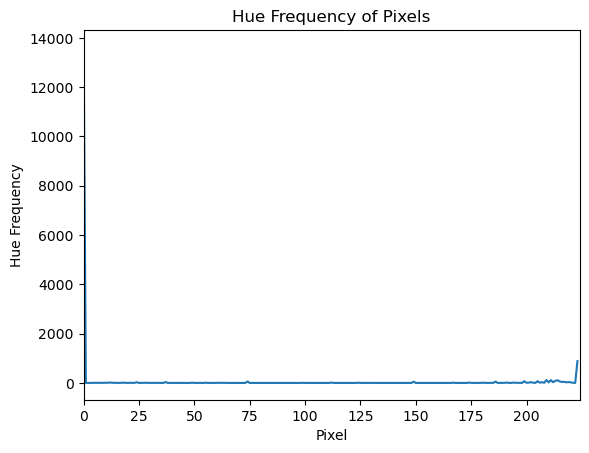

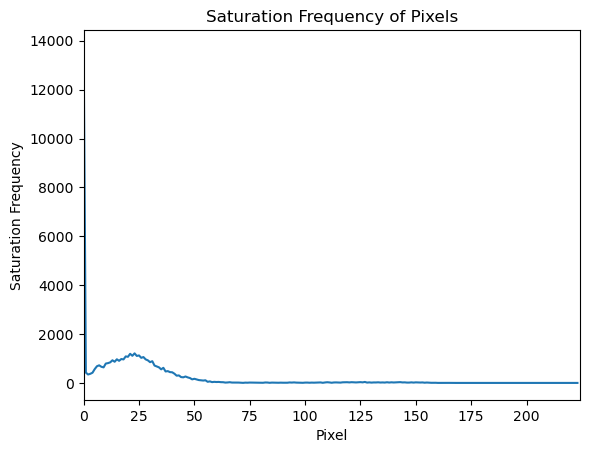

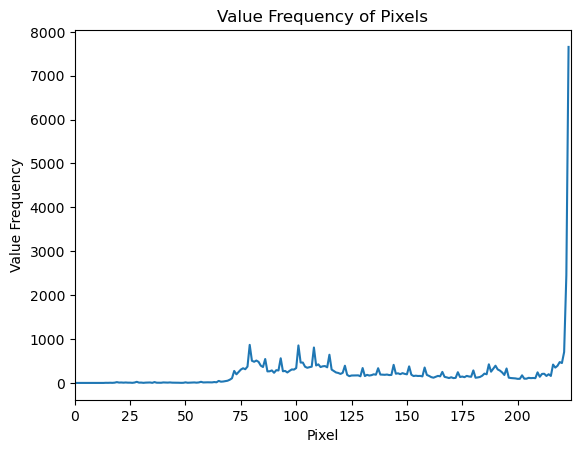

In [522]:
#Take the first picture in the train picture as an example to show the HSV feature
def plot_histogram(bins, values, ylabel, title):
    plt.plot(bins, values)
    plt.xlim(0, 224) 
    plt.xlabel('Pixel')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Get the first image of augmented data as the example
hue_hist_sample = HUE_data_train[0][0]         # The first dimension is HUE
saturation_hist_sample = HUE_data_train[0][1]  # The second dimension is Saturation
value_hist_sample = HUE_data_train[0][2]       # The third dimension is Vlue

# Set the range of X as the size the pixels
bins = np.arange(0, 224)
#Plot the histogram
plot_histogram(bins, hue_hist_sample, 'Hue Frequency', 'Hue Frequency of Pixels')
plot_histogram(bins, saturation_hist_sample, 'Saturation Frequency', 'Saturation Frequency of Pixels')
plot_histogram(bins, value_hist_sample, 'Value Frequency', 'Value Frequency of Pixels')

In [481]:
HUE_train_data_shape = (len(HUE_data_train),) + tuple(np.shape(HUE_data_train[0]))
print(HUE_train_data_shape)

HUE_test_data_shape = (len(HUE_data_test),) + tuple(np.shape(HUE_data_test[0]))
print(HUE_test_data_shape)

HUE_aug_data_shape = (len(HUE_data_aug),) + tuple(np.shape(HUE_data_aug[0]))
print(HUE_aug_data_shape)

(150, 3, 224)
(40, 3, 224)
(600, 3, 224)


### Convert 

In [538]:
def increase_contrast(image, alpha):
    image_float = image.astype(float)
    # Adjust the contrast of image
    contrast_image = cv2.convertScaleAbs(image_float, alpha=alpha, beta=0)
    
    return contrast_image

convert_data_train = []
convert_data_test = []
convert_data_aug = []

#Ilterate the image of test, train and augmented dataloaders
#Set the contrast adjustment parameter alpha as 1 (with the best performance after testing)
#In order to plot focus on the wound without the impact of other elements

for images in test_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.multiply(image_np, 255).astype(np.uint8) #Adjust to range 0-255
        image_np = np.transpose(image_np, (1, 2, 0))
        convert_data = increase_contrast(image_np, alpha=1)  
       
        convert_data_test.append(convert_data)

for images in train_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.multiply(image_np, 255).astype(np.uint8) #Adjust to range 0-255
        image_np = np.transpose(image_np, (1, 2, 0))
        convert_data = increase_contrast(image_np, alpha=1)
       
        convert_data_train.append(convert_data)

for images in aug_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.multiply(image_np, 255).astype(np.uint8) #Adjust to range 0-255
        image_np = np.transpose(image_np, (1, 2, 0))
        convert_data = increase_contrast(image_np, alpha=1)
       
        convert_data_aug.append(convert_data)

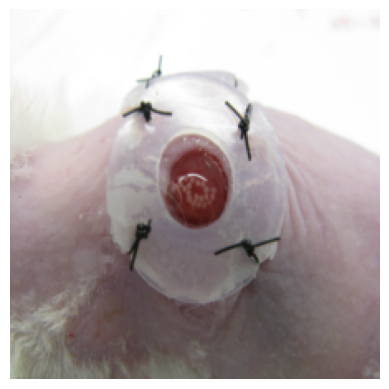

In [539]:
#Take the first picture in the train picture as an example to show the converted effect
plt.imshow(convert_data_train[0])
plt.axis('off')
plt.show()

### Hue mask

#### Without Convert 

In [540]:
#Without using the converted images, use the original image to do the HUE MASK
#In order to highlight the important hue and the structural features of images

def red_color_binary(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Split the hue channel
    hue_channel = hsv_image[:,:,0]
    # Set the range of hue channel from 40 to 360 (with the best performance after testing)
    binary_hue_image = np.where((hue_channel >= 40) & (hue_channel <= 360), 225, 0)

    return binary_hue_image

red_data_train = []
red_data_test = []
red_data_aug = []

#Ilterate the images of train, test and augmented dataloaders transforming into binary images
for images in train_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0)) 
        red_data = red_color_binary(image_np)
       
        red_data_train.append(red_data)

for images in test_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        red_data = red_color_binary(image_np)
       
        red_data_test.append(red_data)
        
for images in aug_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        red_data = red_color_binary(image_np)
       
        red_data_aug.append(red_data)

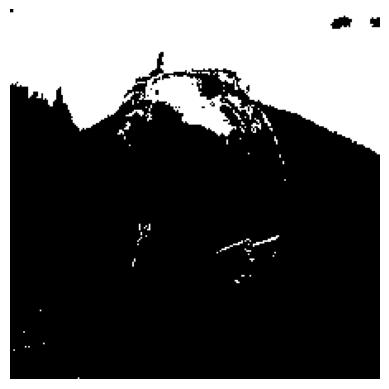

In [504]:
#Take the first picture in the train picture as an example to show the HUE MASK feaures
plt.imshow(red_data_train[0], cmap='binary')
plt.axis('off')
plt.show()

#### With Convert

Do NOT need to run when review the project, since this features would not be used in the final model.

In [536]:
#Use the converted images above to do the HUE Mask
#In order to focus on the position of wound

def red_color_binary(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Split the hue channel
    hue_channel = hsv_image[:,:,0]
    # Set the range of hue channel from 40 to 360 (with the best performance)
    binary_hue_image = np.where((hue_channel >= 40) & (hue_channel <= 360), 225, 0)

    return binary_hue_image

red_data_train = []
red_data_test = []
red_data_aug = []

#Ilterate the converted images of train, test and augmented dataloaders
for image in convert_data_train:
    red_data = red_color_binary(image)   
    red_data_train.append(red_data)

for image in convert_data_test:
    red_data = red_color_binary(image)
    red_data_test.append(red_data)

for image in convert_data_aug:
    red_data = red_color_binary(image)
    red_data_aug.append(red_data)

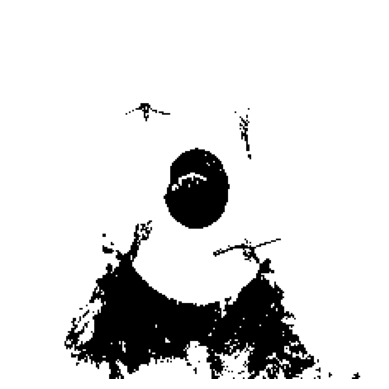

In [537]:
#Take the first picture in the train picture as an example to show the HUE MASK feaures after being converted
plt.imshow(red_data_train[0], cmap='binary')
plt.axis('off')
plt.show()

In [506]:
red_data_train_shape = (len(red_data_train),) + tuple(np.shape(red_data_train[0]))
print(red_data_train_shape)

red_data_test_shape = (len(red_data_test),) + tuple(np.shape(red_data_test[0]))
print(red_data_test_shape)

red_data_aug_shape = (len(red_data_aug),) + tuple(np.shape(red_data_aug[0]))
print(red_data_aug_shape)

(150, 224, 224)
(40, 224, 224)
(600, 224, 224)


### Texture

In [507]:
from skimage import feature as skif

#Use Local Binary Pattern method to extract the texture features of image
#In order to reduce the impact of color
#Set the radius of sampling as 13 and points of sampling as 30 (with the best performance after test)

def getLbpData(image, lbp_radius=13, lbp_point=30):
    lbp = skif.local_binary_pattern(image, lbp_point, lbp_radius, 'default').astype(int)
    return lbp

LBP_train_data = []
LBP_test_data = []
LBP_aug_data = []

#Ilterate the images of train, test and augmented dataloaders transforming into LBP gray images
for images in train_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

        lbp_features = getLbpData(image_gray)     
        LBP_train_data.append((lbp_features))
        
for images in test_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
        
        lbp_features = getLbpData(image_gray)
        LBP_test_data.append((lbp_features))    

for images in aug_dataloader:
    for image in images:
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
        
        lbp_features = getLbpData(image_gray) 
        LBP_aug_data.append((lbp_features))

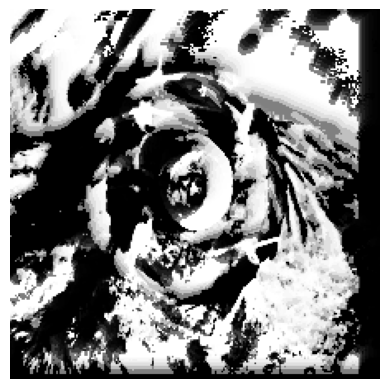

In [508]:
#Take the first picture in the train picture as an example to show the LBP feaures
plt.imshow(LBP_train_data[0], cmap='gray')
plt.axis('off')
plt.show()

In [300]:
LBP_train_data_shape = (len(LBP_train_data),) + tuple(np.shape(LBP_train_data[0]))
print(LBP_train_data_shape)

LBP_test_data_shape = (len(LBP_test_data),) + tuple(np.shape(LBP_test_data[0]))
print(LBP_test_data_shape)

LBP_aug_data_shape = (len(LBP_aug_data),) + tuple(np.shape(LBP_aug_data[0]))
print(LBP_aug_data_shape)

(150, 224, 224)
(40, 224, 224)
(600, 224, 224)


# SVR Model

### Data Preparation

In [580]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Data processing in the following step:
#Features combination of train, test and augmented images respectively
#Reshape the features into two dimensional metrix (each image one row)
#Combine the Y values into one metrix
#Concatenate the features as X value

#The final result using LBP and HUE MASK features as the best performance

hue_train_features = np.array(HUE_data_train).reshape(150, -1)
lbp_train_features = np.array(LBP_train_data).reshape(150, -1)
RGB_train_features = np.array(RGB_train_features).reshape(150, -1)
red_train_features = np.array(red_data_train).reshape(150, -1)

xy_width = np.array([x_train_list, y_train_list, x_train_width_list, y_train_width_list]).T

# train_data = np.concatenate((hue_train_features, lbp_train_features, RGB_train_features, red_train_features, xy_width), axis=1)
train_data = np.concatenate((lbp_train_features, red_train_features, xy_width), axis=1)

hue_aug_features = np.array(HUE_data_aug).reshape(600, -1)
lbp_aug_features = np.array(LBP_aug_data).reshape(600, -1)
RGB_aug_features = np.array(RGB_aug_features).reshape(600, -1)
red_aug_features = np.array(red_data_aug).reshape(600, -1)

xy_width = np.array([augmented_x_train_list, augmented_y_train_list, augmented_x_train_width_list, augmented_y_train_width_list]).T

# aug_data = np.concatenate((hue_aug_features, lbp_aug_features, RGB_aug_features, red_aug_features, xy_width), axis=1)
aug_data = np.concatenate((lbp_aug_features, red_aug_features, xy_width), axis=1)

hue_test_features = np.array(HUE_data_test).reshape(40, -1)
lbp_test_features = np.array(LBP_test_data).reshape(40, -1)
RGB_test_features = np.array(RGB_test_features).reshape(40, -1)
red_test_features = np.array(red_data_test).reshape(40, -1)

xy_width = np.array([x_test_list, y_test_list, x_test_width_list, y_test_width_list]).T

# test_data = np.concatenate((hue_test_features, lbp_test_features, RGB_test_features, red_test_features, xy_width), axis=1)
test_data = np.concatenate((lbp_test_features, red_test_features, xy_width), axis=1)

# Split the data into X and Y values
X_train = train_data[:, :-4]
y_train = train_data[:, -4:]
X_aug = aug_data[:, :-4]
y_aug = aug_data[:, -4:]
X_test = test_data[:, :-4]
y_test = test_data[:, -4:]

#Use the Standart Scaler method to normalize the X values
#In order to maintain the relative relationship between features to avoid numerical differences affecting the results
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_aug_scaled = X_scaler.fit_transform(X_aug)
X_test_scaled = X_scaler.transform(X_test)

#Randomly split 0.2 in training data as validation data
#Use the augmented images as training data (with the best performance after testing)
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_aug_scaled, y_aug, test_size=0.2, random_state=42)


In [589]:
import pickle

# save X_test_scaled and y_test for tester
with open('X_test_scaled.pkl', 'wb') as file:
    pickle.dump(X_test_scaled, file)
with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [581]:
#Check the shape of each features and the currently shape of train, val and test data

hue_train_features_shape = (len(hue_train_features),) + tuple(np.shape(hue_train_features[0]))
print(f"hue shape: {hue_train_features_shape}")
lbp_train_features_shape = (len(lbp_train_features),) + tuple(np.shape(lbp_train_features[0]))
print(f"lbp shape: {lbp_train_features_shape}")
RGB_train_features_shape = (len(RGB_train_features),) + tuple(np.shape(RGB_train_features[0]))
print(f"RGB shape: {RGB_train_features_shape}")
red_train_features_shape = (len(red_train_features),) + tuple(np.shape(red_train_features[0]))
print(f"red shape: {red_train_features_shape}")

train_data_shape = (len(X_train_scaled),) + tuple(np.shape(X_train_scaled[0]))
print(f"train data shape: {train_data_shape}")
val_data_shape = (len(X_val_scaled),) + tuple(np.shape(X_val_scaled[0]))
print(f"val data shape: {val_data_shape}")
test_data_shape = (len(X_test_scaled),) + tuple(np.shape(X_test_scaled[0]))
print(f"test data shape: {test_data_shape}")

hue shape: (150, 672)
lbp shape: (150, 50176)
RGB shape: (150, 150528)
red shape: (150, 50176)
train data shape: (480, 100352)
val data shape: (120, 100352)
test data shape: (40, 100352)


### Train Model 

In [516]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

#Use Cross Validation to choose the best parameters' combination
#Use SVR as model, combined with MultiOutput Regressor predicting four values at once

#Build the model environment
svr_model = SVR()
multioutput_model = MultiOutputRegressor(svr_model)

param_grid = {
    'estimator__kernel': ['linear', 'rbf'],    # Types of kernel in SVR
    'estimator__C': [0.1, 1, 10, 50, 75, 100], # Penalty parameter in SVR
    'estimator__epsilon': [0.01, 0.1, 1]       # Tolerance parameter in SVR
}

# Perform the cross validation by GridSearch
# Setting the number of flod as 5 and the scoring indicator as MSE
grid_search = GridSearchCV(multioutput_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Output the best combination of parameters and the corresponding MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_
print("Best combination of parameters：", best_params)
print("The average MSE of Cross-Validation：", best_mse)

Best combination of parameters： {'estimator__C': 0.1, 'estimator__epsilon': 0.01, 'estimator__kernel': 'linear'}
The average MSE of Cross-Validation： 437.3294923024998


In [586]:
import time

svr_model = SVR(kernel='linear', C=0.1, epsilon=0.01)
multioutput_model = MultiOutputRegressor(svr_model)

# Record the starting time
start_time = time.time()

# Train model
multioutput_model.fit(X_train_scaled, y_train)
        
# Calculate the MSE loss of train and validation set correspondingly
y_train_pred = multioutput_model.predict(X_train_scaled) 
Train_mse_loss = mean_squared_error(y_train, y_train_pred)

y_val_pred = multioutput_model.predict(X_val_scaled)
val_mse_loss = mean_squared_error(y_val, y_val_pred)

# Record the ending time
end_time = time.time()
epoch_time = end_time - start_time

# Output the result
print(f"Training MSE: {Train_mse_loss} -  Validation MSE: {val_mse_loss} - Time elapsed: {epoch_time} seconds\n")

Training MSE: 0.00010013907959463405 -  Validation MSE: 202.42998072977898 - Time elapsed: 217.5176134109497 seconds



In [556]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Use the Cross-Validation to measure the model's performance

# Setting the number of flod as 5 and the scoring indicator as MSE
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# Do the Cross-Validation on the training and validation data
train_scores = cross_val_score(multioutput_model, X_train_scaled, y_train, cv=kfold, scoring='neg_mean_squared_error')
val_scores = cross_val_score(multioutput_model, X_val_scaled, y_val, cv=kfold, scoring='neg_mean_squared_error')

# Change the MSE to positive value
train_mse_scores = -train_scores
val_mse_scores = -val_scores

# Output the MSE of each fold and the mean MSE of training and validation data
for i, mse in enumerate(train_mse_scores):
    print(f"Fold {i+1} MSE: {mse}")
print(f"Mean of Train MSE: {train_mse_scores.mean()}")

for i, mse in enumerate(val_mse_scores):
    print(f"Fold {i+1} MSE: {mse}")
print(f"Mean of Validation MSE: {val_mse_scores.mean()}")

Fold 1 MSE: 99.45454239622211
Fold 2 MSE: 97.95585568829006
Fold 3 MSE: 271.29330520805524
Fold 4 MSE: 234.33587976815738
Fold 5 MSE: 89.92121821019283
Mean of Train MSE: 158.5921602541835
Fold 1 MSE: 1741.9309265557922
Fold 2 MSE: 1396.046584902539
Fold 3 MSE: 2635.982415149061
Fold 4 MSE: 1614.1767731226669
Fold 5 MSE: 1760.7873975870034
Mean of Validation MSE: 1829.7848194634128


### Test Model 

In [587]:
import joblib

#Save model
joblib.dump(multioutput_model, 'model.pkl')

['model.pkl']

In [584]:
#Load model for testing data

loaded_model = joblib.load('model.pkl')

# Record the starting time
start_time = time.time()

#Do the prediction using the trained model and calculate the MSE loss
y_test_pred = loaded_model.predict(X_test_scaled)
Test_mse_loss = mean_squared_error(y_test, y_test_pred)

# Record the ending time
end_time = time.time()
epoch_time = end_time - start_time
# Output the result
print(f"Testing MSE: {Test_mse_loss} - Time elapsed: {epoch_time} seconds\n")

Testing MSE: 1483.1018982084156 - Time elapsed: 11.320176839828491 seconds



### Visualization of Performance

In [585]:
# Load the path of test folder
test_images_folder = test_dir

# build the output folder
output_folder = "performance-visualization"
os.makedirs(output_folder, exist_ok=True)

# Ilterate the testing images
for i in range(len(y_test)):
    
    #Read image by the corresponding file name in test folder
    filename = filename_test_list[i]
    image_path = os.path.join(test_images_folder, f"{filename}")
    image = cv2.imread(image_path)
    
    # Decompose the corresponding actual values and predicted values
    actual_center_x, actual_center_y, actual_width, actual_height = y_test[i]
    pred_center_x, pred_center_y, pred_width, pred_height = y_test_pred[i]

    # Draw the actual center point
    cv2.circle(image, (int(actual_center_x), int(actual_center_y)), 5, (0, 0, 255), -1)
    # Draw the actual wound location oval
    cv2.ellipse(image, (int(actual_center_x), int(actual_center_y)), (int(actual_width/2), int(actual_height/2)), 0, 0, 360, (0, 0, 255), 2)
    
    # Draw prediction center point
    cv2.circle(image, (int(pred_center_x), int(pred_center_y)), 5, (0, 255, 0), -1)
    # Draw a predicted wound location oval
    cv2.ellipse(image, (int(pred_center_x), int(pred_center_y)), (int(pred_width/2), int(pred_height/2)), 0, 0, 360, (0, 255, 0), 2)
    # Save the annotated image
    output_path = os.path.join(output_folder, f"{filename}_annotated.jpg")
    cv2.imwrite(output_path, image)